# t-SNE를 통한 환자 군집 분석

이 노트북에서는 Essential 데이터셋의 혈액검사 결과를 t-SNE로 차원 축소하여 환자 군집을 탐색합니다.

## 분석 목표
1. 혈액검사 패턴에 따른 환자 군집 발견
2. 군집과 사망률의 관계 분석
3. 군집과 입원기간의 관계 분석

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

# 한글 폰트 설정
import platform
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. 데이터 로딩 및 전처리

In [2]:
# 데이터 로드
df = pd.read_csv('../../analysis_prediction/data/essential/model_dataset_essential.csv')

print(f"데이터셋 크기: {df.shape}")
print(f"\n컬럼 목록:")
print(df.columns.tolist())

# 혈액검사 특성 정의
lab_features = [
    'Hematocrit_51221_merged',
    'Hemoglobin_51222',
    'Creatinine_50912_merged',
    'RDW_51277',
    'White_Blood_Cells_51301_merged',
    'Urea_Nitrogen_51006_merged',
    'Potassium_50971_merged',
    'Sodium_50983_merged',
    'Glucose_50931'
]

print(f"\n혈액검사 항목 ({len(lab_features)}개):")
for feature in lab_features:
    print(f"  - {feature}")

데이터셋 크기: (1200, 23)

컬럼 목록:
['hadm_id', 'subject_id', 'admittime', 'dischtime', 'deathtime', 'dod', 'death_type', 'death_binary', 'hospital_death', 'los_hours', 'los_days', 'age', 'gender', 'admission_type', 'Hematocrit_51221_merged', 'Hemoglobin_51222', 'Creatinine_50912_merged', 'RDW_51277', 'White_Blood_Cells_51301_merged', 'Urea_Nitrogen_51006_merged', 'Potassium_50971_merged', 'Sodium_50983_merged', 'Glucose_50931']

혈액검사 항목 (9개):
  - Hematocrit_51221_merged
  - Hemoglobin_51222
  - Creatinine_50912_merged
  - RDW_51277
  - White_Blood_Cells_51301_merged
  - Urea_Nitrogen_51006_merged
  - Potassium_50971_merged
  - Sodium_50983_merged
  - Glucose_50931


In [3]:
# 데이터 전처리
# 혈액검사 데이터 추출
X_labs = df[lab_features].copy()

# 결측값 처리 (중앙값으로 대체)
imputer = SimpleImputer(strategy='median')
X_labs_imputed = imputer.fit_transform(X_labs)

# 정규화
scaler = StandardScaler()
X_labs_scaled = scaler.fit_transform(X_labs_imputed)

print(f"전처리 완료: {X_labs_scaled.shape}")
print(f"평균: {X_labs_scaled.mean():.4f}")
print(f"표준편차: {X_labs_scaled.std():.4f}")

전처리 완료: (1200, 9)
평균: 0.0000
표준편차: 1.0000


## 2. 기본 t-SNE 분석 (혈액검사만)

In [4]:
# t-SNE 실행 (perplexity=30)
print("t-SNE 실행 중... (약 1-2분 소요)")

tsne_30 = TSNE(n_components=2, 
                perplexity=30,
                max_iter=1000,
                random_state=42,
                learning_rate=200)

X_tsne_30 = tsne_30.fit_transform(X_labs_scaled)

print(f"t-SNE 완료: {X_tsne_30.shape}")
print(f"KL divergence: {tsne_30.kl_divergence_:.4f}")

t-SNE 실행 중... (약 1-2분 소요)


t-SNE 완료: (1200, 2)
KL divergence: 1.2658


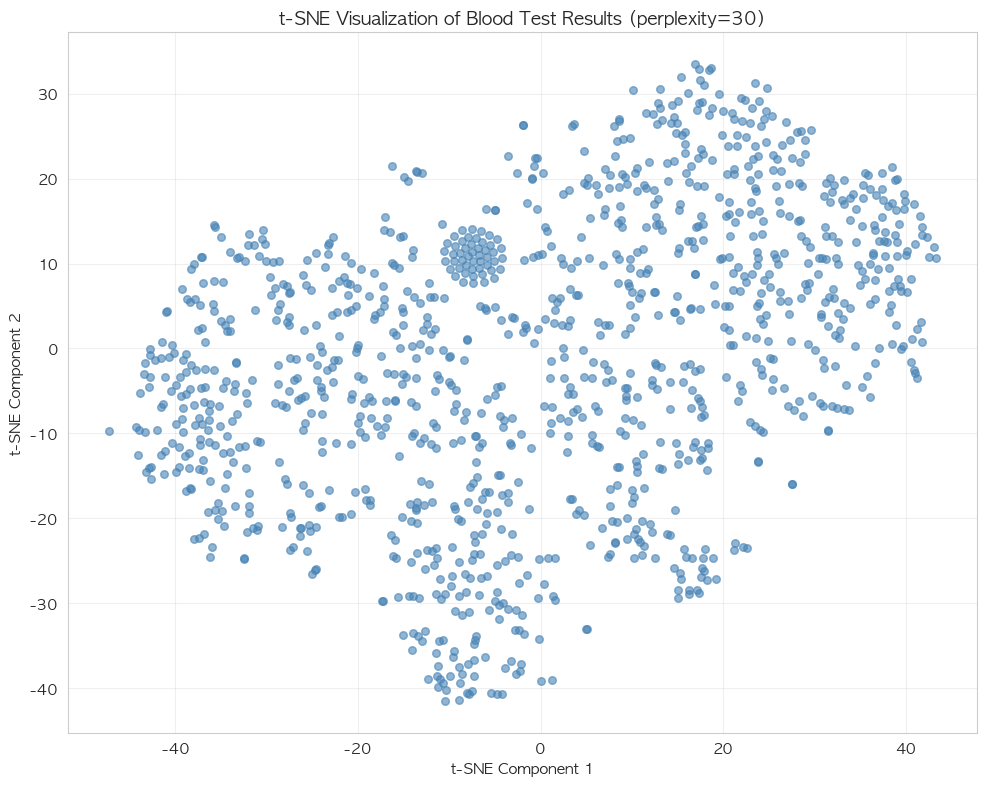

In [5]:
# 기본 t-SNE 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne_30[:, 0], X_tsne_30[:, 1], 
                     alpha=0.6, s=30, c='steelblue')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Blood Test Results (perplexity=30)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/tsne_basic.png', dpi=100, bbox_inches='tight')
plt.show()

## 3. 성별 및 입원유형별 군집 분석

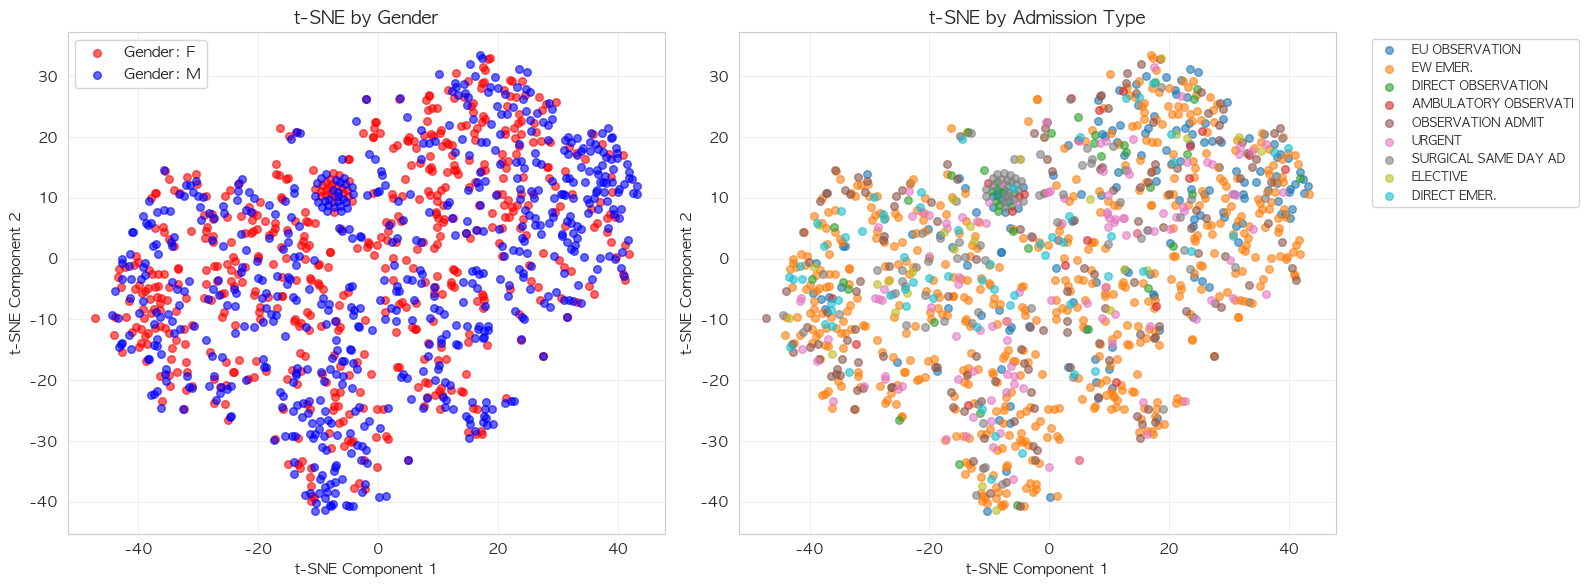

In [6]:
# 성별로 색상 구분
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 성별 시각화
gender_colors = {'M': 'blue', 'F': 'red'}
for gender in df['gender'].unique():
    mask = df['gender'] == gender
    axes[0].scatter(X_tsne_30[mask, 0], X_tsne_30[mask, 1], 
                   label=f'Gender: {gender}',
                   alpha=0.6, s=30, c=gender_colors[gender])

axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_title('t-SNE by Gender')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 입원 유형별 시각화
admission_types = df['admission_type'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(admission_types)))

for i, adm_type in enumerate(admission_types):
    mask = df['admission_type'] == adm_type
    axes[1].scatter(X_tsne_30[mask, 0], X_tsne_30[mask, 1], 
                   label=adm_type[:20],  # 긴 이름 축약
                   alpha=0.6, s=30, c=[colors[i]])

axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_title('t-SNE by Admission Type')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/tsne_gender_admission.png', dpi=100, bbox_inches='tight')
plt.show()

In [7]:
# 사망 관련 색상과 라벨 정의 (전역 사용)
death_colors = {0: 'green', 1: 'red'}
death_labels = {0: 'Survived', 1: 'Died'}

## 4. 사망 관련 분석

Perplexity=50으로 t-SNE 실행 중...


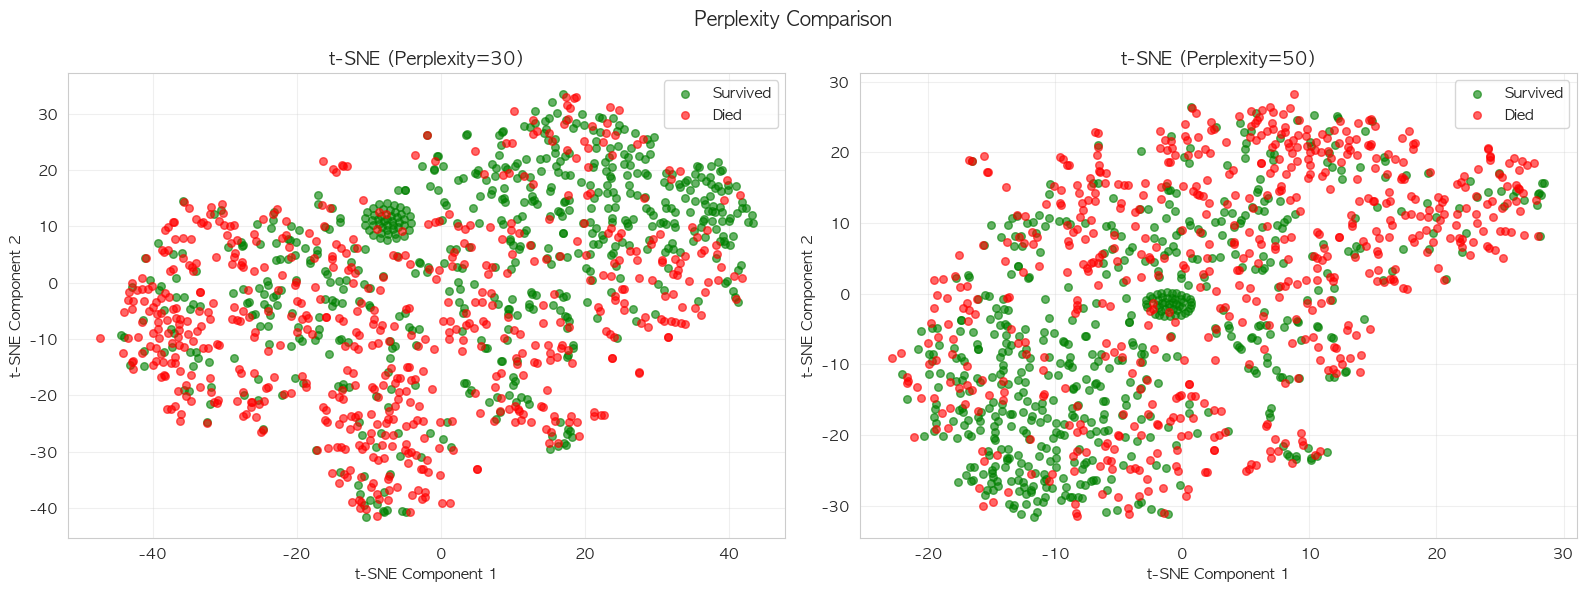

KL divergence (perplexity=30): 1.2658
KL divergence (perplexity=50): 1.1856


In [8]:
# 다른 perplexity로 t-SNE 실행
print("Perplexity=50으로 t-SNE 실행 중...")

tsne_50 = TSNE(n_components=2, 
                perplexity=50,
                max_iter=1000,
                random_state=42,
                learning_rate=200)

X_tsne_50 = tsne_50.fit_transform(X_labs_scaled)

# 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Perplexity=30
for death in [0, 1]:
    mask = df['death_binary'] == death
    axes[0].scatter(X_tsne_30[mask, 0], X_tsne_30[mask, 1], 
                   label=death_labels[death],
                   alpha=0.6, s=30, c=death_colors[death])

axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_title('t-SNE (Perplexity=30)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity=50
for death in [0, 1]:
    mask = df['death_binary'] == death
    axes[1].scatter(X_tsne_50[mask, 0], X_tsne_50[mask, 1], 
                   label=death_labels[death],
                   alpha=0.6, s=30, c=death_colors[death])

axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_title('t-SNE (Perplexity=50)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Perplexity Comparison', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/tsne_perplexity_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"KL divergence (perplexity=30): {tsne_30.kl_divergence_:.4f}")
print(f"KL divergence (perplexity=50): {tsne_50.kl_divergence_:.4f}")

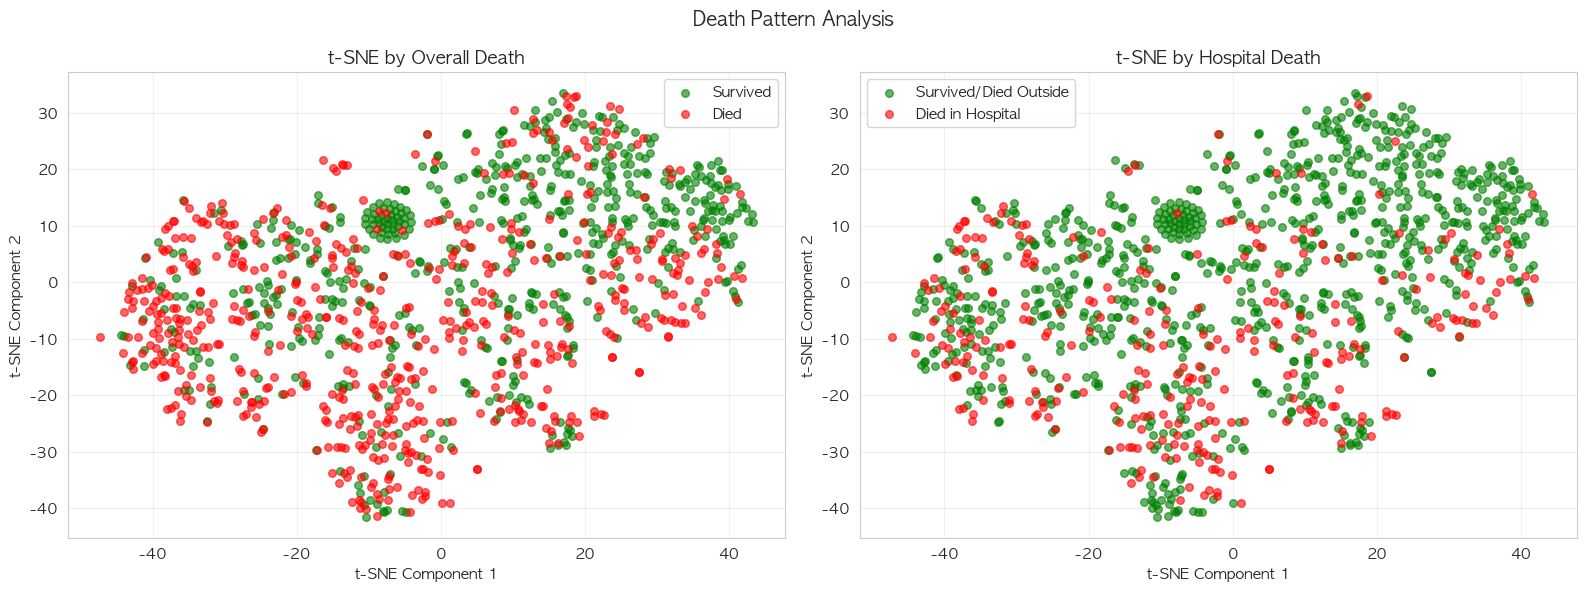

In [9]:
# 사망 여부별 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 전체 사망 (death_binary)
death_colors = {0: 'green', 1: 'red'}
death_labels = {0: 'Survived', 1: 'Died'}

for death in [0, 1]:
    mask = df['death_binary'] == death
    axes[0].scatter(X_tsne_30[mask, 0], X_tsne_30[mask, 1], 
                   label=death_labels[death],
                   alpha=0.6, s=30, c=death_colors[death])

axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_title('t-SNE by Overall Death')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 병원 내 사망 (hospital_death)
for death in [0, 1]:
    mask = df['hospital_death'] == death
    label = 'Died in Hospital' if death == 1 else 'Survived/Died Outside'
    axes[1].scatter(X_tsne_30[mask, 0], X_tsne_30[mask, 1], 
                   label=label,
                   alpha=0.6, s=30, c=death_colors[death])

axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_title('t-SNE by Hospital Death')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Death Pattern Analysis', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/tsne_death_patterns.png', dpi=100, bbox_inches='tight')
plt.show()

## 5. 입원기간 분석

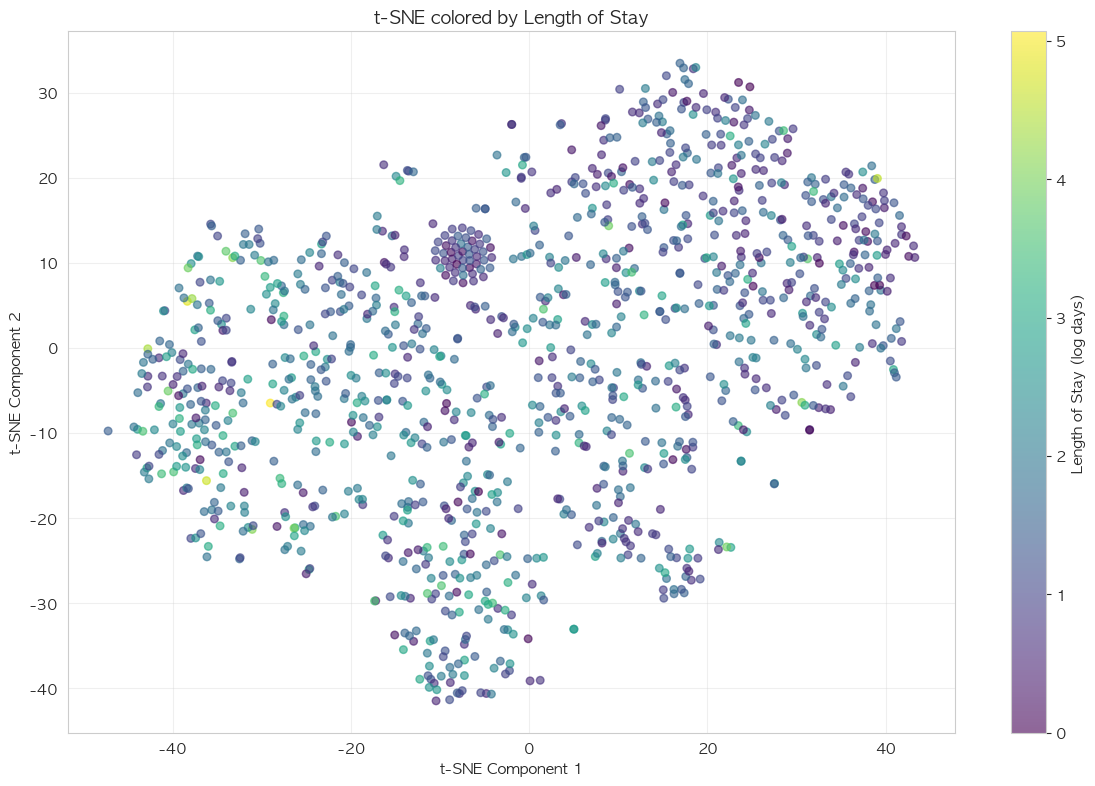

입원기간 통계:
count    1200.000000
mean        6.389216
std        10.480003
min         0.000000
25%         1.451389
50%         3.552778
75%         7.007465
max       157.838194
Name: los_days, dtype: float64


In [10]:
# 입원기간을 색상 gradient로 표현
plt.figure(figsize=(12, 8))

# Log scale for better visualization
los_days_log = np.log1p(df['los_days'].values)

scatter = plt.scatter(X_tsne_30[:, 0], X_tsne_30[:, 1], 
                     c=los_days_log, cmap='viridis',
                     alpha=0.6, s=30)

plt.colorbar(scatter, label='Length of Stay (log days)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE colored by Length of Stay')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/tsne_los.png', dpi=100, bbox_inches='tight')
plt.show()

# 입원기간 통계
print("입원기간 통계:")
print(df['los_days'].describe())

## 6. 군집 분석

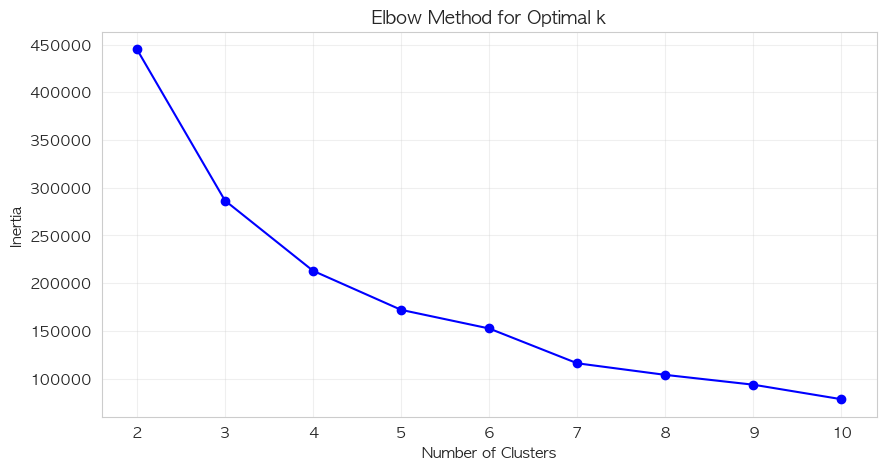

In [11]:
# K-means 클러스터링으로 군집 정의
from sklearn.cluster import KMeans

# 최적 클러스터 수 찾기 (Elbow method)
inertias = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tsne_30)
    inertias.append(kmeans.inertia_)

# Elbow plot
plt.figure(figsize=(10, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.savefig('../figures/elbow_plot.png', dpi=100, bbox_inches='tight')
plt.show()

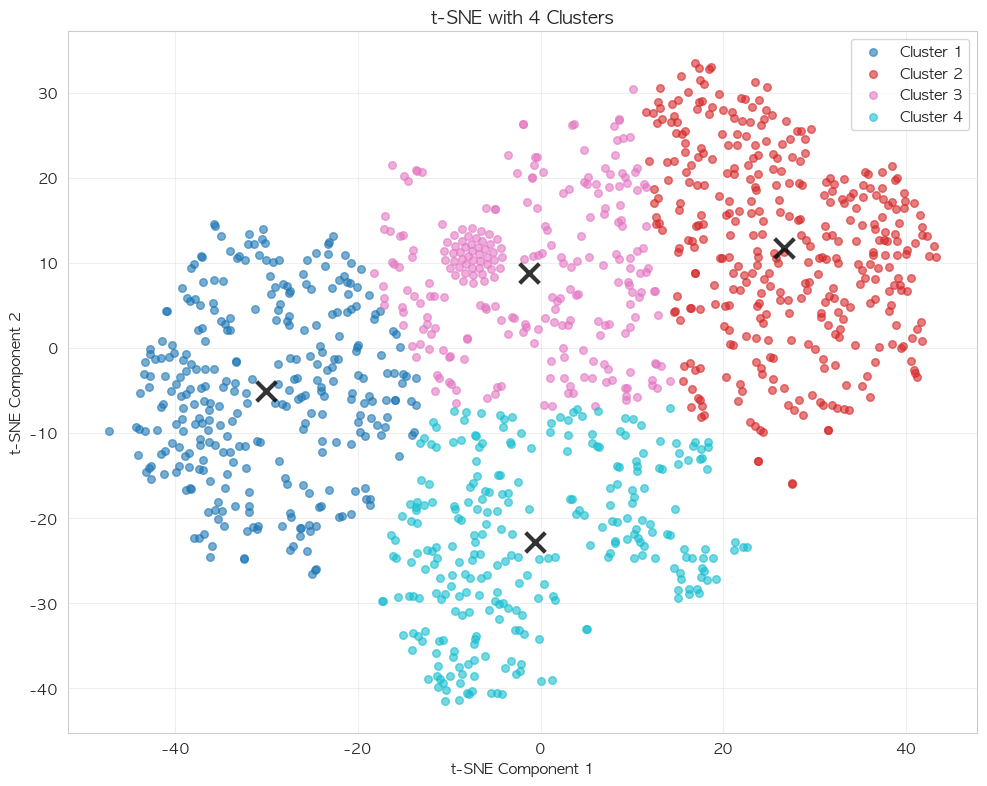

In [12]:
# 4개 클러스터로 분류 (예시)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_tsne_30)

# 클러스터 시각화
plt.figure(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for i in range(n_clusters):
    mask = clusters == i
    plt.scatter(X_tsne_30[mask, 0], X_tsne_30[mask, 1], 
               label=f'Cluster {i+1}',
               alpha=0.6, s=30, c=[colors[i]])

# 클러스터 중심점 표시
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], 
           c='black', s=200, alpha=0.8, marker='x', linewidths=3)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title(f't-SNE with {n_clusters} Clusters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/tsne_clusters.png', dpi=100, bbox_inches='tight')
plt.show()

In [13]:
# 클러스터별 특성 분석
df['cluster'] = clusters

print("="*60)
print("클러스터별 통계")
print("="*60)

for i in range(n_clusters):
    cluster_data = df[df['cluster'] == i]
    print(f"\n클러스터 {i+1} (n={len(cluster_data)}):")
    print(f"  - 사망률: {cluster_data['death_binary'].mean():.2%}")
    print(f"  - 병원 내 사망률: {cluster_data['hospital_death'].mean():.2%}")
    print(f"  - 평균 입원기간: {cluster_data['los_days'].mean():.1f} days")
    print(f"  - 평균 나이: {cluster_data['age'].mean():.1f} years")
    print(f"  - 남성 비율: {(cluster_data['gender']=='M').mean():.2%}")

클러스터별 통계

클러스터 1 (n=309):
  - 사망률: 64.40%
  - 병원 내 사망률: 31.39%
  - 평균 입원기간: 9.9 days
  - 평균 나이: 63.6 years
  - 남성 비율: 46.28%

클러스터 2 (n=360):
  - 사망률: 32.78%
  - 병원 내 사망률: 12.50%
  - 평균 입원기간: 4.4 days
  - 평균 나이: 59.1 years
  - 남성 비율: 59.44%

클러스터 3 (n=256):
  - 사망률: 35.94%
  - 병원 내 사망률: 14.84%
  - 평균 입원기간: 4.8 days
  - 평균 나이: 61.0 years
  - 남성 비율: 38.67%

클러스터 4 (n=275):
  - 사망률: 69.45%
  - 병원 내 사망률: 43.64%
  - 평균 입원기간: 6.5 days
  - 평균 나이: 71.6 years
  - 남성 비율: 60.36%


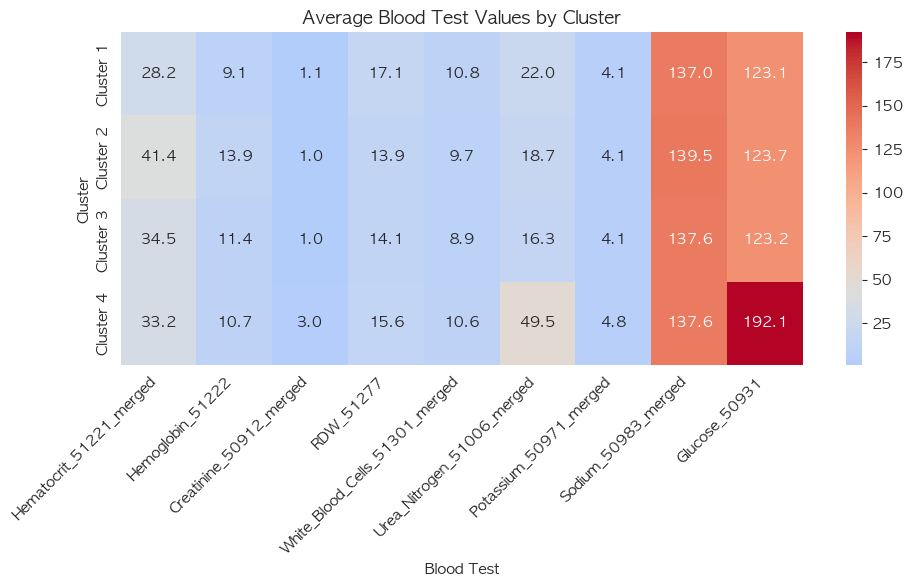

In [14]:
# 클러스터별 혈액검사 평균값
cluster_means = pd.DataFrame()

for i in range(n_clusters):
    cluster_data = df[df['cluster'] == i]
    means = cluster_data[lab_features].mean()
    cluster_means[f'Cluster {i+1}'] = means

# Heatmap으로 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, annot=True, fmt='.1f', cmap='coolwarm', 
            center=cluster_means.mean().mean())
plt.title('Average Blood Test Values by Cluster')
plt.xlabel('Blood Test')
plt.ylabel('Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../figures/cluster_heatmap.png', dpi=100, bbox_inches='tight')
plt.show()

Perplexity=50으로 t-SNE 실행 중...


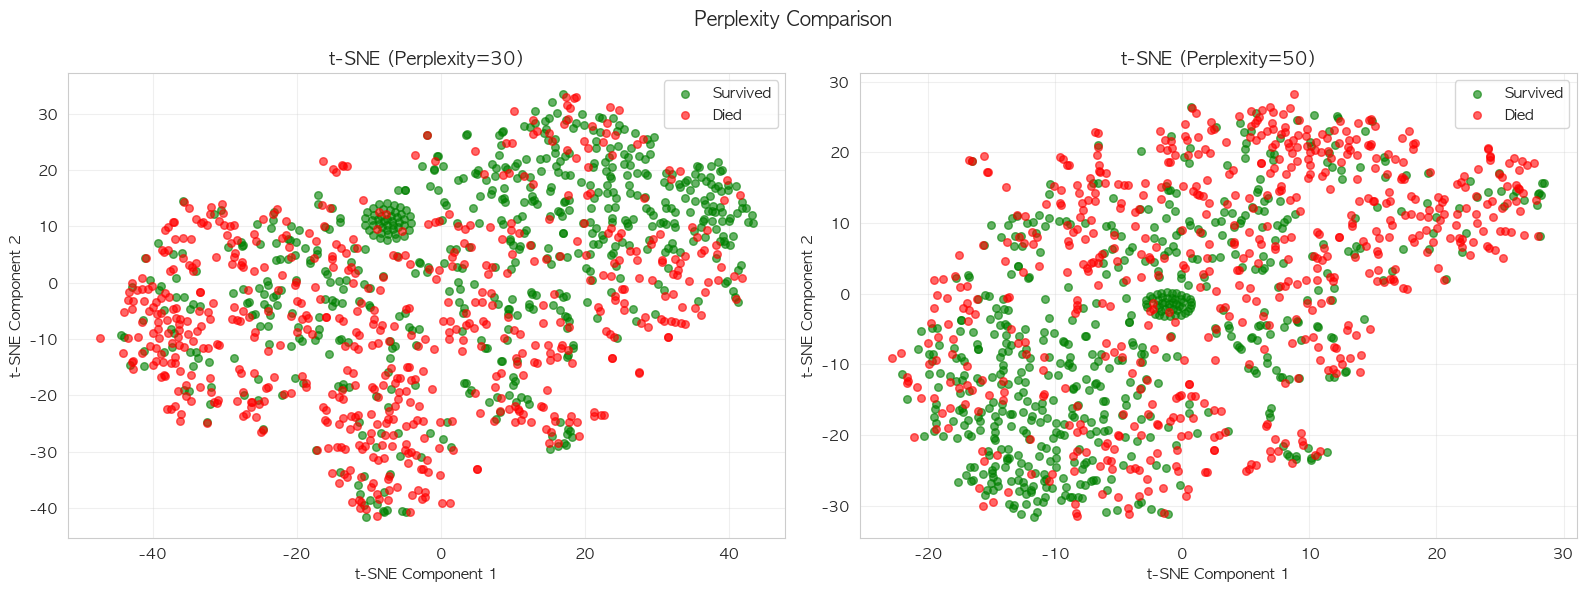

KL divergence (perplexity=30): 1.2658
KL divergence (perplexity=50): 1.1856


In [15]:
# 다른 perplexity로 t-SNE 실행
print("Perplexity=50으로 t-SNE 실행 중...")

tsne_50 = TSNE(n_components=2, 
                perplexity=50,
                max_iter=1000,
                random_state=42,
                learning_rate=200)

X_tsne_50 = tsne_50.fit_transform(X_labs_scaled)

# 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Perplexity=30
for death in [0, 1]:
    mask = df['death_binary'] == death
    axes[0].scatter(X_tsne_30[mask, 0], X_tsne_30[mask, 1], 
                   label=death_labels[death],
                   alpha=0.6, s=30, c=death_colors[death])

axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_title('t-SNE (Perplexity=30)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity=50
for death in [0, 1]:
    mask = df['death_binary'] == death
    axes[1].scatter(X_tsne_50[mask, 0], X_tsne_50[mask, 1], 
                   label=death_labels[death],
                   alpha=0.6, s=30, c=death_colors[death])

axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_title('t-SNE (Perplexity=50)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Perplexity Comparison', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/tsne_perplexity_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"KL divergence (perplexity=30): {tsne_30.kl_divergence_:.4f}")
print(f"KL divergence (perplexity=50): {tsne_50.kl_divergence_:.4f}")

## 9. 결과 저장

## 8. 확장 분석: 혈액검사 + 인구통계

# 혈액검사 + 나이 포함
X_extended = df[lab_features + ['age']].copy()

# 전처리
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_extended_imputed = imputer.fit_transform(X_extended)
X_extended_scaled = scaler.fit_transform(X_extended_imputed)

print("확장 데이터로 t-SNE 실행 중...")
tsne_extended = TSNE(n_components=2, 
                      perplexity=30,
                      max_iter=1000,
                      random_state=42)

X_tsne_extended = tsne_extended.fit_transform(X_extended_scaled)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 혈액검사만
scatter1 = axes[0].scatter(X_tsne_30[:, 0], X_tsne_30[:, 1], 
                           c=df['age'].values, cmap='plasma',
                           alpha=0.6, s=30)
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_title('t-SNE: Blood Tests Only')
plt.colorbar(scatter1, ax=axes[0], label='Age')
axes[0].grid(True, alpha=0.3)

# 혈액검사 + 나이
scatter2 = axes[1].scatter(X_tsne_extended[:, 0], X_tsne_extended[:, 1], 
                           c=df['age'].values, cmap='plasma',
                           alpha=0.6, s=30)
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_title('t-SNE: Blood Tests + Age')
plt.colorbar(scatter2, ax=axes[1], label='Age')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Impact of Including Age in t-SNE', fontsize=14)
plt.tight_layout()
plt.savefig('../figures/tsne_with_age.png', dpi=100, bbox_inches='tight')
plt.show()